In [2]:
import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import warnings 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt  

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

In [5]:
# Let’s read train and test datasets.

train  = pd.read_csv('data/train_E6oV3lV.csv') 
test = pd.read_csv('data/test_tweets_anuFYb8.csv')

In [6]:
train[train['label'] == 0].head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
6,7,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
7,8,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,9,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦
9,10,0,@user @user welcome here ! i'm it's so #gr8 !


In [7]:
train[train['label'] == 1].head(10)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk folx running around loving themselves and promoting our greatness
77,78,1,"@user hey, white people: you can call people 'white' by @user #race #identity #medâ¦"
82,83,1,how the #altright uses &amp; insecurity to lure men into #whitesupremacy
111,112,1,@user i'm not interested in a #linguistics that doesn't address #race &amp; . racism is about #power. #raciolinguistics bringsâ¦


In [8]:
train.shape, test.shape

((31962, 3), (17197, 2))

In [9]:
train["label"].value_counts()

0    29720
1     2242
Name: label, dtype: int64

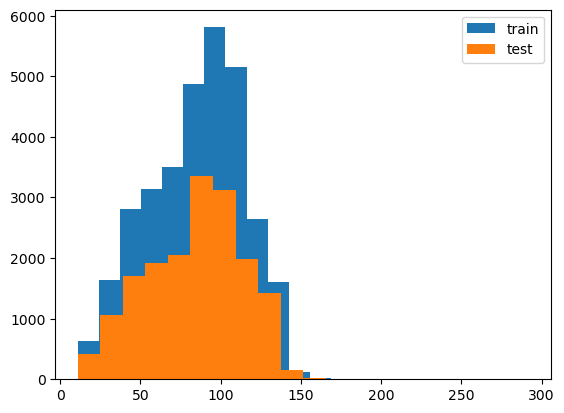

In [10]:
plt.hist(train.tweet.str.len(), bins=20, label='train')
plt.hist(test.tweet.str.len(), bins=20, label='test')
plt.legend()
plt.show()

In [11]:
combi = train.append(test, ignore_index=True, sort=True)
combi.shape

/tmp/ipykernel_1540936/2276653185.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combi = train.append(test, ignore_index=True, sort=True)


(49159, 3)

In [12]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt


Tweet Specific Cleaning

In [13]:


combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*") 
combi.tidy_tweet = combi.tidy_tweet.str.replace("[^a-zA-Z#]", " ")
combi.tidy_tweet = combi.tidy_tweet.apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))
tokenized_tweet = combi.tidy_tweet.apply(lambda x: x.split())

/tmp/ipykernel_1540936/2607419696.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  combi.tidy_tweet = combi.tidy_tweet.str.replace("[^a-zA-Z#]", " ")


In [14]:
from nltk.stem.porter import * 
stemmer = PorterStemmer() 
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0                   [when, father, dysfunct, selfish, drag, kid, into, dysfunct, #run]
1    [thank, #lyft, credit, caus, they, offer, wheelchair, van, #disapoint, #getthank]
2                                                              [bihday, your, majesti]
3                                                     [#model, love, take, with, time]
4                                                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

In [15]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])    
combi['tidy_tweet'] = tokenized_tweet

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
import gensim
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])
bow.shape

(49159, 1000)

In [34]:
# Extracting train and test BoW features 
train_bow = bow[:31962,:] 
test_bow = bow[31962:,:] 

# splitting data into training and validation set 
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'], random_state=42, test_size=0.3)

lreg = LogisticRegression(solver='lbfgs') 

# training the model 
lreg.fit(xtrain_bow, ytrain) 
prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set 
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int) # calculating f1 score for the validation set

0.5303408146300915

In [18]:
import gensim
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split()) # tokenizing 

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
) 

model_w2v.train(tokenized_tweet, total_examples= len(combi['tidy_tweet']), epochs=20)

(6510731, 7536020)

In [19]:
model_w2v.wv.most_similar(positive="dinner")

[('spaghetti', 0.5500274300575256),
 ('#foodcoma', 0.5450606346130371),
 ('#avocado', 0.5441926717758179),
 ('#cellar', 0.5407294631004333),
 ('reggio', 0.5306890606880188),
 ('cookout', 0.5282652378082275),
 ('#biall', 0.5279924273490906),
 ('spinach', 0.5272848606109619),
 ('alfredo', 0.526782214641571),
 ('noodl', 0.5262755751609802)]

In [20]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [21]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(49159, 200)

Log Regression

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


In [25]:
train_w2v = wordvec_df.iloc[:31962,:]
test_w2v = wordvec_df.iloc[31962:,:]
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_w2v, train['label'], random_state=42, test_size=0.3)

xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]
lreg = LogisticRegression(solver='lbfgs') 
lreg.fit(xtrain_w2v, ytrain) 

prediction = lreg.predict_proba(xvalid_w2v)

prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int)

0.6272793581327498

In [29]:
test_w2v

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
31962,0.179672,-0.187208,-0.066549,-0.000242,0.046900,-0.168585,0.107313,-0.398923,-0.004514,0.449174,...,-0.103199,0.187785,0.257544,0.188475,-0.307286,-0.209163,-0.120206,0.215510,0.000477,0.310378
31963,-0.150212,-0.076864,0.291058,0.107394,-0.031307,0.054426,0.048535,-0.088110,-0.148706,0.319648,...,-0.037505,0.288227,0.449524,0.131449,0.131855,-0.234407,0.154804,0.231847,-0.197378,-0.021180
31964,0.256323,-0.685308,0.037841,0.156358,0.175741,-0.455709,0.204166,-0.071353,-0.166744,0.358992,...,-0.097271,0.117643,0.481305,0.131040,-0.609189,-0.103460,-0.414897,0.257788,-0.005154,0.115262
31965,-0.156354,-0.084167,-0.045204,0.261206,-0.351160,0.024167,0.094944,0.015713,-0.018836,0.192259,...,-0.115195,-0.040670,0.123306,-0.118127,-0.124392,-0.273800,-0.085134,-0.077520,-0.039422,0.122772
31966,-0.201948,-0.377420,0.078496,0.255450,0.106117,-0.294889,0.178293,0.137301,-0.320276,0.088791,...,-0.163226,0.159545,0.288092,0.003622,-0.047590,-0.151903,-0.133241,0.142705,0.188242,0.163408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49154,0.426450,-0.303092,-0.130385,-0.091316,-0.287552,-0.445654,0.143336,-0.350281,-0.101861,0.073121,...,-0.370203,0.027233,0.591174,0.196856,-0.128439,-0.263338,0.012271,-0.019405,0.179523,0.157480
49155,-0.066160,-0.146003,0.021755,-0.027590,-0.066405,-0.083718,0.006630,-0.148369,-0.152469,0.219024,...,0.015671,0.042999,0.110882,0.134621,-0.047660,-0.146282,0.013817,0.366585,-0.161911,0.169529
49156,-0.014664,-0.359236,0.207952,0.161144,0.057906,-0.243625,0.132200,-0.016686,-0.042993,-0.047490,...,-0.264327,0.083821,0.107700,0.065275,-0.230917,-0.069272,-0.177468,0.013672,-0.142921,0.038789
49157,-0.079377,-0.294929,-0.226446,0.120460,-0.484782,-0.436563,0.351299,-0.323529,0.008292,0.510716,...,-0.257282,0.044352,0.560298,0.096884,-0.465877,-0.180334,-0.128337,-0.065687,0.191225,0.469466


In [32]:
lreg.predict_proba(test_w2v)[:,1] >= 0.3

array([False, False, False, ...,  True, False, False])